# Building RandomForestClassifier models

This notebook:
* builds several RandomForestClassifier models to experiment with performance in response to different formats of input data
* Demonstrates failures in 4 different attempts at using GridSearchCV to obtain the best hyperparameters for a RandomForestClassifer model (including 2 attempts to run on a GPU on Google Colab)

In [262]:
from modules.utility import Utility
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline as IMBPipeline

import pickle

In [263]:
# # Uncomment code as required to force reload utility.py
# # Was only required during development of this notebook

# from importlib import reload
# import modules.utility
# reload(modules.utility)
# from modules.utility import Utility

# Setup

Remove display limits for column and row lengths, for easier viewing of dataframes

In [264]:
# Set no limits for number of columns and rows to display
# Utility.reset_display_max_cols_rows() to reset
Utility.setup_display_max_cols_rows()

Load the cleaned data

In [265]:
# Load the final, melted, cleaned dataset
df = Utility.get_clean_waittimes_dataframe()
df.head()

,datetime,hospital,waittime,year,dayofweek,numdayofweek,weekofyear,hour,dayperiod,id,services,city,cityarea,citypop,citytype,hosplat,hosplong
0,2022-09-24 18:22:00,Alberta Children's Hospital,201.0,2022,Saturday,5,38,18,evening,ach,emergency,Calgary,826,1306784,urban,51.074759,-114.146833
1,2022-09-24 18:22:00,Chinook Regional Hospital,69.0,2022,Saturday,5,38,18,evening,crh,emergency,Lethbridge,122,98406,peri,49.685221,-112.816209
2,2022-09-24 18:22:00,Devon General Hospital,132.0,2022,Saturday,5,38,18,evening,dgh,emergency,Devon,14,6545,rural,53.352265,-113.728288
3,2022-09-24 18:22:00,Foothills Medical Centre,188.0,2022,Saturday,5,38,18,evening,fmc,emergency,Calgary,826,1306784,urban,51.064657,-114.130926
4,2022-09-24 18:22:00,Fort Sask Community Hospital,295.0,2022,Saturday,5,38,18,evening,fsch,emergency,Fort Saskatchewan,48,27088,rural,53.693175,-113.213436


In [266]:
# Original df shape
df.shape

(201151, 17)

Remove 'Urgent Care' facilities so we are only modelling on ERs

In [267]:
# Filter the dataframe to be only Emergency services
ER_SERVICES_MASK = Utility.MASK_EMERGENCY_SERVICES(df)
df = df[ER_SERVICES_MASK]

In [268]:
# df shape after dropping 'urgentcare' services
df.shape

(181926, 17)

# Prepare data for modeling

Try a logistic regression classification learning model where y = binary outcome of long wait, where I have **defined long wait as "greater than 400 minutes (6.67 hours)"**.

This '400 minute' choice was based on the following:
* Looking at the descriptive statistics for the entire dataset or ER hospitals
* Calculating the upper bound for outliers (`Q3 + IQR*1.5`) cut off for ER hospitals (500 minutes)
* The following national guidelines, with images shown in readme.md:
    - Canadian ED Triage & Acuity Scale, 1998: https://ctas-phctas.ca/wp-content/uploads/2018/05/ctased16_98.pdf
        - Specifying lowest triage level (Level V) should have time to physician <= 2 hours
    - CAEP (Canadian Associate of Emergency Physicians) Position Statement, 2013: "Emergency department overcrowding and access block":  https://caep.ca/wp-content/uploads/2016/03/cjem_2013_overcrowding_and_access_block.pdf
        - Specifying recommendation for median 1 hour to PIA and 3 hours at 90% percentile
    - Alberta Health Performance Measure Definition for TPIA (Time to Physician Initial Assessment) (Feb 2015): https://open.alberta.ca/dataset/c7e3fc16-7aea-455c-96a1-20811a640b1a/resource/e2f49c22-3390-48a3-ac74-278a932aa668/download/pmd-ed-time-physician-initial-assessment.pdf
        - Specifying national sides averaging 3.2 hours, Alberta sites averaging 3.1 hours (in 2012-13)
    - "Physician Initial Assessment Times Based on CTAS Scores: Are We Meeting the Recommendations?": https://www.longwoods.com/content/26333/healthcare-quarterly/physician-initial-assessment-times-based-on-ctas-scores-are-we-meeting-the-recommendations-
        - Specifying "overall compliance with recommended PIA times was low" in 4 community EDs around Hamilton, Ontario from 2016-2017.


Feature Engineer:
* longwait: 0 or 1

Drop:
* datetime
* hospital (we will use 'id' instead)
* waittime (we are using our binary value of 'longwait' instead, because this is a classification problem)
* year
* numdayofweek (we will use 'dayofweek' instead)
* services (they are all 'emergency' based on our earlier filter)
* cityarea
* citypop
* hosplat
* hosplong

We will also do additional feature engineering to simplify features:
* collapse citytype 'peri' into 'rural', and keep this feature

**NOTE: I have defined constants and utility functions in the `Utility` class in `modules.utility` (modules/utility.py file) to ensure consistency in shaping the dataframe that is ultimately used for modelling, in each classifier I build.**

In [269]:
# Create new dataframe called df_model
df_model = df.copy()

# Collapse citytype 'peri' into 'rural'.  This is a valid assumption as demonstrated by plots in the erwait_eda_hypothesis_testing.ipynb notebook.
Utility.collapse_periurban_to_rural(df_model)

# Engineer the new feature 'longwait'
Utility.add_longwait_feature(df_model)

# Drop unwanted columns, which are defined as Utility.LOGIT_DROP_COLS, for consistent use in every notebook for every classification model.
Utility.drop_unwanted_columns(df_model, Utility.LOGIT_DROP_COLS)

Confirm how the dataframe looks after:
* Collapsing peri to rural
* Adding the 'longwait' feature (this will be our target variable)
* Dropping unwanted columns/features

In [270]:
Utility.display_df_general_info(df_model)
# display(df_model.head())
# print(f"\nShape of df_model: {df_model.shape}")
# print(f"\nColumns of df_model: {df_model.columns}")
# print(f"\ndtypes of df_model: {df_model.dtypes}")

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Saturday,38,18,evening,ach,Calgary,urban,0
1,Saturday,38,18,evening,crh,Lethbridge,rural,0
2,Saturday,38,18,evening,dgh,Devon,rural,0
3,Saturday,38,18,evening,fmc,Calgary,urban,0
4,Saturday,38,18,evening,fsch,Fort Saskatchewan,rural,0



Shape of dataframe:
(181926, 8)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city',
       'citytype', 'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     object
weekofyear     int64
hour           int64
dayperiod     object
id            object
city          object
citytype      object
longwait       int64
dtype: object


Sort the dataframe a consistent and particular way (as defined in Utility class) prior to one-hot encoding, so that the one-hot encoding is consistent across all notebooks for all classification models.

In [271]:
df_model = Utility.sort_df_before_encoding_or_modeling(df_model)

Check what it looks like after sorting


In [272]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


# BRANCH FOR DIFFERENT MODELS AT THIS POINT.
AT THIS POINT IN THE NOTEBOOK, THE FOUNDATIONAL DATA SETUP THAT IS SHARED BY THE MODELS FOLLOWING, HAS BEEN SETUP.

BRANCH HERE

# Modelling Plans

We will build 5 Random Forest models and compare results as follows, each with `class_weight=balanced` to inherently deal with the class imbalance in our data:
(reference: https://stackoverflow.com/questions/40565444/balanced-random-forest-in-scikit-learn-python)

| Model   Name         | Feature Columns                                                                                                                            | Target Column | One-Hot Encoded Columns                                                                                    | Label Encoded Columns    | Names of columns not one-hot   encoded                        | Datatypes of non-one-hot-encoded   columns   | Class Counts                                                                                                      | Main Question                                                                                                                                                                          |
|----------------------|--------------------------------------------------------------------------------------------------------------------------------------------|---------------|------------------------------------------------------------------------------------------------------------|--------------------------|---------------------------------------------------------------|----------------------------------------------|-------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| baseline             | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | None                     | 'weekofyear', 'hour'                                          | 'hour': category      'weekofyear': category | Imbalanced: '1': 93.3%, '0': 6.7%, imbalanced handled by setting   class_weight=balanced on the Classifier object | What is baseline performance for basic XGBoostClassifier model?                                                                                                                        |
| onehot               | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.RFC_ONEHOT_COLS_ALL:      'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype' | None                     | All columns one-hot encoded                                   | N/A                                          | Imbalanced: '1': 93.3%, '0': 6.7%, imbalanced handled by setting   class_weight=balanced on the Classifier object | What is performance when all features one-hot encoded?                                                                                                                                 |
| onehot_dropdayperiod | Remove 'dayperiod' from columns,   as it is collinear:      ''dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype'                   | 'longwait'    |      'dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype'                                           | None                     | N/A                                                           | N/A                                          | Imbalanced: '1': 93.3%, '0': 6.7%, imbalanced handled by setting   class_weight=balanced on the Classifier object | What is performance when 'dayperiod' (column that is collinear with   'hour' ) is dropped, but every column, otherwise, is one-hot encoded?                                            |
| labelencoded         | Remove 'dayperiod' from columns,   as it is collinear:      Resulting cols = 'dayofweek', 'weekofyear', 'hour', 'id', 'city',   'citytype' | 'longwait'    | None                                                                                                       | All                      | All columns are not one-hot   encoded (all are Label Encoded) | int64 via Label Encoding                     | Imbalanced: '1': 93.3%, '0': 6.7%, imbalanced handled by setting   class_weight=balanced on the Classifier object | Does making all features Label Encoded and thereby reducing   dimensionality (and also removing removing the 'dayperiod' which is   multicollinear with 'hour'), increase performance? |
| labelpartial         | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | dayofweek', 'weekofyear' | Label encoded columns: 'dayofweek', 'weekofyear'              | int64 via Label Encoding                     | Imbalanced: '1': 93.3%, '0': 6.7%, imbalanced handled by setting   class_weight=balanced on the Classifier object | Does reintroducing one-hot encoding for most columns, but making   'weekofyear' and 'hour' label encoded (partial reduction of dimensionality)   increase performance?                 |

## Build RandomForestClassifier model: "baseline"

In [273]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_onehot_cols_a = Utility.one_hot_encode_categorical_columns(df_model, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_onehot_cols_a)

Convert 'hour' and 'weekofyear' to category types

In [274]:
df_model_onehot_cols_a['hour'] = df_model_onehot_cols_a['hour'].astype('category')
df_model_onehot_cols_a['weekofyear'] = df_model_onehot_cols_a['weekofyear'].astype('category')

How does the dataframe look?

In [275]:
Utility.display_df_general_info(df_model_onehot_cols_a)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                      category
longwait                     int64
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofwee

## Set X and y dataframes for "baseline" model

In [276]:
X_model = (df_model_onehot_cols_a.drop(['longwait'], axis=1))
y_model = (df_model_onehot_cols_a['longwait'])

## Train-Test Split for Model: "baseline"

In [277]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [278]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `class_weights='balanced'` in our RandomForestClassifier

In [279]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [280]:
baseline_rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced')
baseline_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [281]:
# Get predictions for X_train and X_test
y_train_pred = baseline_rfc.predict(X_train)
y_test_pred = baseline_rfc.predict(X_test)

## Evaluate model performance: "baseline"

Confusion Matrix

In [282]:
# Confusion Matrix
print("\nResults on TRAINING data:")
baseline_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9725,10
Actual Negative,1798,134007



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,914,1609
Actual Negative,1111,32752


ROC Curve


Results on TRAINING data:


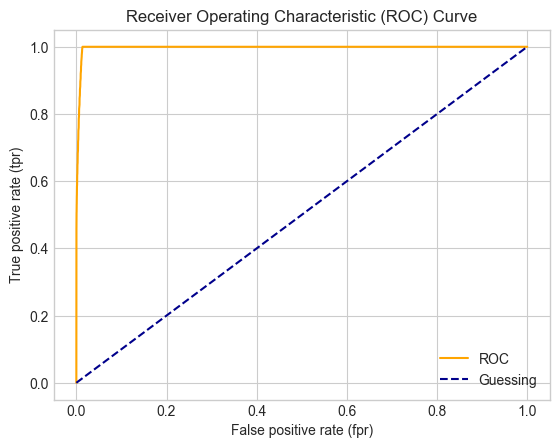


Results on TEST data:


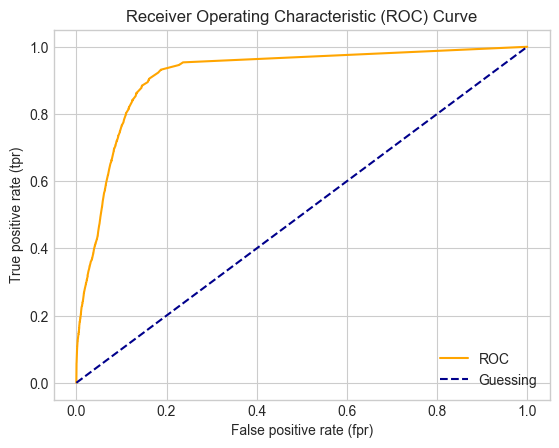

In [283]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = baseline_rfc.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = baseline_rfc.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [284]:
# Scores
print("\nResults on TRAINING data:")
baseline_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      98.76%
Precision           :       0.84
Recall              :       1.00
F1 score            :       0.91
F1 (macro) score    :       0.95
F1 (weighted) score :       0.99
ROC-AUC             :       0.99

Results on TEST data:
Accuracy            :      92.52%
Precision           :       0.45
Recall              :       0.36
F1 score            :       0.40
F1 (macro) score    :       0.68
F1 (weighted) score :       0.92
ROC-AUC             :       0.66


Finding: We can see that the model is overfit to the training data given the significant difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.66 is not as good as the best simple logit models built, though.

# Looking at Feature Importances

Information from: https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

Code credit to user "fordy".

"Higher score means that specific feature will have a larger effect on the model." (https://builtin.com/data-science/feature-importance)

Show feature importances

weekofyear                0.343046
hour                      0.224841
citytype_urban            0.071132
dayperiod_night           0.057218
dayperiod_evening         0.032562
id_plc                    0.016482
id_uah                    0.015897
id_gnch                   0.015360
id_mch                    0.014878
city_Edmonton             0.014658
dayofweek_Monday          0.012624
dayofweek_Saturday        0.012102
dayofweek_Sunday          0.011206
id_shc                    0.009811
dayofweek_Tuesday         0.009774
dayofweek_Wednesday       0.008893
id_stollery               0.008719
id_fmc                    0.008513
dayofweek_Thursday        0.008310
city_Medicine Hat         0.008132
id_nchc                   0.008108
id_rah                    0.007772
id_rgh                    0.007411
city_Lethbridge           0.007349
id_mhrh                   0.006953
id_crh                    0.005824
id_lch                    0.005288
id_dgh                    0.005221
city_Leduc          

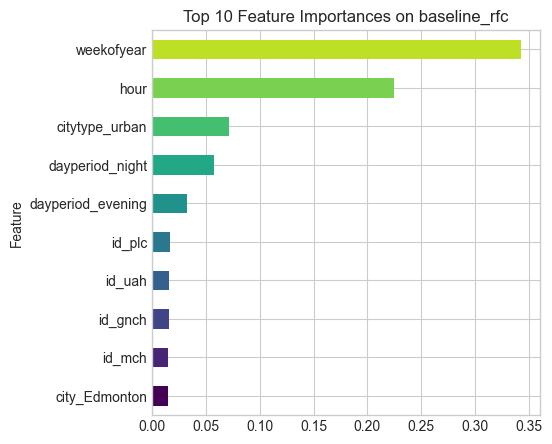

In [285]:
feat_importances = Utility.get_feature_importances_and_plot(baseline_rfc, X_train, 'baseline_rfc')
display(feat_importances)

## Build RandomForestClassifier model: "onehot"

Recall, this is the model where the data have these characteristics:
* all columns one-hot encoded, using Utility.RFC_ONEHOT_COLS_ALL
* 'dayperiod' which is collinear with 'hour', is kept in the data

In [286]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


In [287]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_onehot_cols_all = Utility.one_hot_encode_categorical_columns(df_model, Utility.RFC_ONEHOT_COLS_ALL)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_onehot_cols_all)

How does the dataframe look?

In [288]:
Utility.display_df_general_info(df_model_onehot_cols_all)

,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 110)

Columns of dataframe:
Index(['longwait', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'weekofyear_2', 'weekofyear_3', 'weekofyear_4',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=110)

dtypes of dataframe:
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              in

## Set X and y dataframes for "onehot" and "onehot_dropdayperiod" models

In [289]:
X_model = (df_model_onehot_cols_all.drop(['longwait'], axis=1))
y_model = (df_model_onehot_cols_all['longwait'])

## Train-Test Split for Model: "onehot"

In [290]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [291]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `class_weights='balanced'` in our RandomForestClassifier

In [292]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [293]:
onehot_rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced')
onehot_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [294]:
# Get predictions for X_train and X_test
y_train_pred = onehot_rfc.predict(X_train)
y_test_pred = onehot_rfc.predict(X_test)

## Evaluate model performance: "onehot"

Confusion Matrix

In [295]:
# Confusion Matrix
print("\nResults on TRAINING data:")
onehot_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9724,11
Actual Negative,1796,134009



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,908,1615
Actual Negative,1093,32770


ROC Curve


Results on TRAINING data:


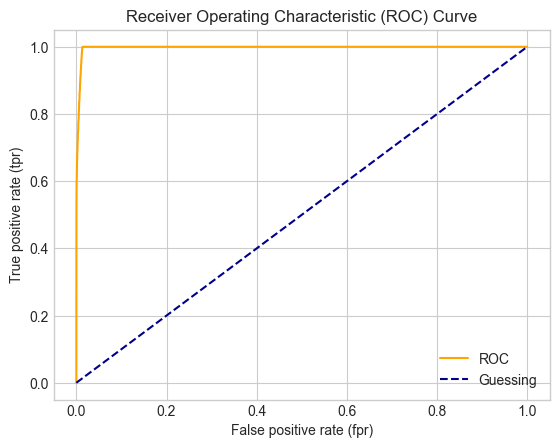


Results on TEST data:


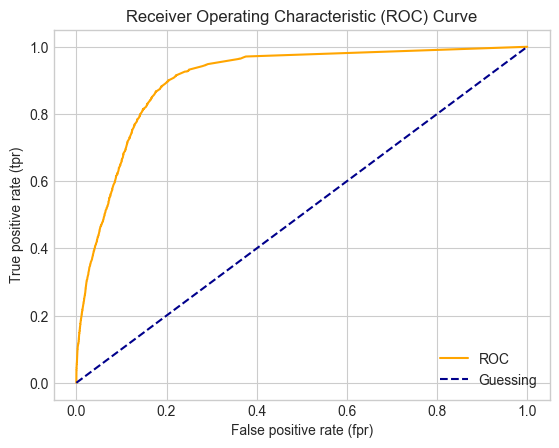

In [296]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = onehot_rfc.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = onehot_rfc.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [297]:
# Scores
print("\nResults on TRAINING data:")
onehot_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      98.76%
Precision           :       0.84
Recall              :       1.00
F1 score            :       0.91
F1 (macro) score    :       0.95
F1 (weighted) score :       0.99
ROC-AUC             :       0.99

Results on TEST data:
Accuracy            :      92.56%
Precision           :       0.45
Recall              :       0.36
F1 score            :       0.40
F1 (macro) score    :       0.68
F1 (weighted) score :       0.92
ROC-AUC             :       0.66


Finding: We can see that the model is overfit to the training data given the significant difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.

Upon first glance, the scores appear exactly the same between the "baseline" and "onehot" RFC models, but we will compare with a closer look later on in the notebook.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.66 is not as good as the best simple logit models built, though.

Show feature importances

dayperiod_night           0.065450
citytype_urban            0.059457
dayperiod_evening         0.026641
hour_23                   0.020111
dayofweek_Wednesday       0.019003
dayofweek_Monday          0.018483
dayofweek_Tuesday         0.018061
id_mch                    0.017940
dayofweek_Saturday        0.017938
id_plc                    0.017902
dayofweek_Thursday        0.017674
id_uah                    0.016233
id_gnch                   0.015837
dayofweek_Sunday          0.015767
city_Edmonton             0.014241
hour_7                    0.013766
weekofyear_41             0.013412
weekofyear_39             0.012491
weekofyear_45             0.012376
weekofyear_44             0.012101
hour_11                   0.011701
weekofyear_46             0.011400
weekofyear_40             0.010970
id_shc                    0.010557
hour_2                    0.010494
hour_10                   0.010455
hour_22                   0.010263
id_fmc                    0.009977
hour_1              

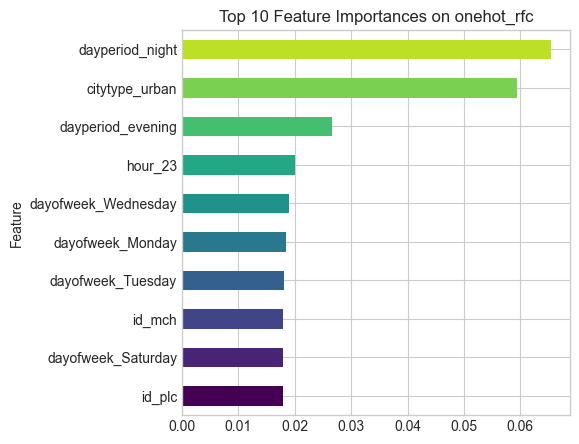

In [298]:
feat_importances = Utility.get_feature_importances_and_plot(onehot_rfc, X_train, 'onehot_rfc')
display(feat_importances)

## Build RandomForestClassifier model: "onehot_dropdayperiod"

Recall, this is the model where the data have these characteristics:
* same as "onehot", where all columns one-hot encoded, using Utility.RFC_ONEHOT_COLS_ALL
* 'dayperiod' which is collinear with 'hour', is dropped from the data

All we need to do is take the last model's X_train and X_test and drop these columns:
* `dayperiod_evening`
* `dayperiod_night`

In [299]:
# Recall what X_model and y_model currently are (from last 'onehot' model setup)
print("X_model.head() from last 'onehot' model setup:")
display(X_model.head())

print("y_model.head() from last 'onehot' model setup:")
display(y_model.head())

X_model.head() from last 'onehot' model setup:


,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


y_model.head() from last 'onehot' model setup:


0    0
1    0
2    0
3    1
4    0
Name: longwait, dtype: int64

Remove `dayperiod_evening` and `dayperiod_night` from `X_train` and `X_test`

In [300]:
X_train.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)
X_test.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)

In [301]:
# What do they look like now?
Utility.display_df_general_info(X_train)
Utility.display_df_general_info(X_test)

,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
94896,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
156867,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
152692,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
22182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
172071,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1



Shape of dataframe:
(145540, 107)

Columns of dataframe:
Index(['dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=107)

dtypes of dataframe:
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              int32
weekofyear_9            

,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
109432,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
59969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
117768,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75800,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1



Shape of dataframe:
(36386, 107)

Columns of dataframe:
Index(['dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=107)

dtypes of dataframe:
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              int32
weekofyear_9             

In [302]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `class_weights='balanced'` in our RandomForestClassifier

In [303]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [304]:
onehot_dropdayperiod_rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced')
onehot_dropdayperiod_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [305]:
# Get predictions for X_train and X_test
y_train_pred = onehot_dropdayperiod_rfc.predict(X_train)
y_test_pred = onehot_dropdayperiod_rfc.predict(X_test)

## Evaluate model performance: "onehot_dropdayperiod"

Confusion Matrix

In [306]:
# Confusion Matrix
print("\nResults on TRAINING data:")
onehot_dropdayperiod_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_dropdayperiod_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9726,9
Actual Negative,1797,134008



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,824,1699
Actual Negative,1147,32716


ROC Curve


Results on TRAINING data:


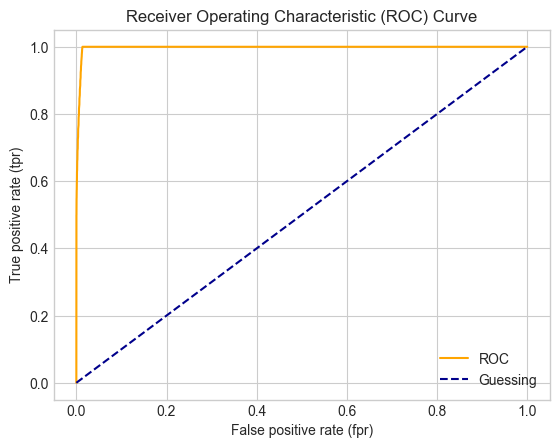


Results on TEST data:


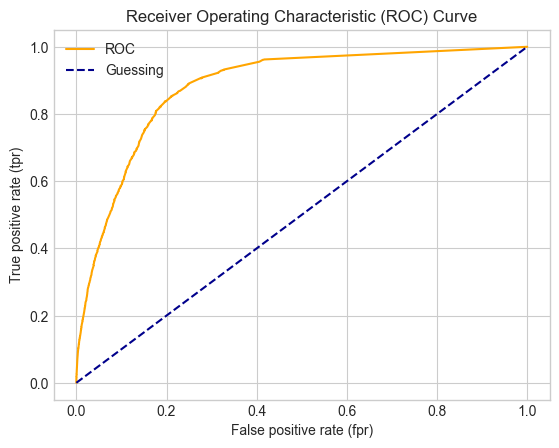

In [307]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = onehot_dropdayperiod_rfc.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = onehot_dropdayperiod_rfc.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [308]:
# Scores
print("\nResults on TRAINING data:")
onehot_dropdayperiod_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_dropdayperiod_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      98.76%
Precision           :       0.84
Recall              :       1.00
F1 score            :       0.92
F1 (macro) score    :       0.95
F1 (weighted) score :       0.99
ROC-AUC             :       0.99

Results on TEST data:
Accuracy            :      92.18%
Precision           :       0.42
Recall              :       0.33
F1 score            :       0.37
F1 (macro) score    :       0.66
F1 (weighted) score :       0.92
ROC-AUC             :       0.65


Finding: We can see that the model is overfit to the training data given the significant difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.

Upon first glance, the scores appear almost exactly the same between the "baseline" and "onehot" RFC models, but we will compare with a closer look later on in the notebook.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.65 is not as good as the best simple logit models built, though.

Show feature importances

citytype_urban            0.061666
hour_11                   0.020372
dayofweek_Monday          0.020133
dayofweek_Wednesday       0.019460
hour_10                   0.019274
id_plc                    0.019074
id_gnch                   0.017964
dayofweek_Thursday        0.017702
hour_12                   0.017557
dayofweek_Tuesday         0.017185
dayofweek_Saturday        0.017183
hour_9                    0.016855
hour_13                   0.016382
hour_2                    0.016132
hour_3                    0.015717
dayofweek_Sunday          0.015615
hour_1                    0.015408
hour_14                   0.014541
hour_15                   0.014240
hour_17                   0.013549
id_mch                    0.013499
hour_18                   0.013407
weekofyear_41             0.013203
hour_16                   0.012961
hour_8                    0.012914
weekofyear_39             0.012112
hour_19                   0.011895
hour_4                    0.011636
weekofyear_45       

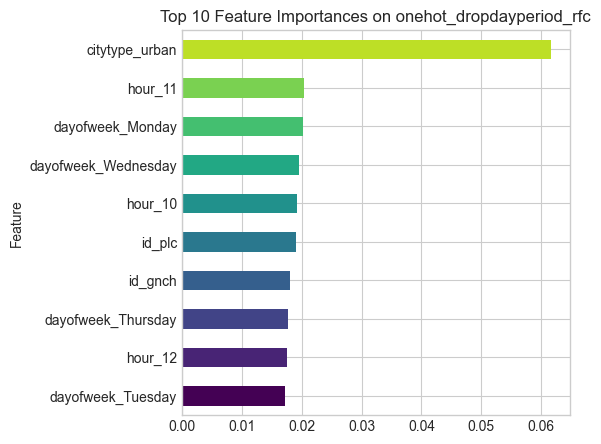

In [309]:
feat_importances = Utility.get_feature_importances_and_plot(onehot_dropdayperiod_rfc, X_train, 'onehot_dropdayperiod_rfc')
display(feat_importances)

## Build RandomForestClassifier model: "labelencoded"

In [310]:
# Make a copy of df_model first
df_model_label = df_model.copy()

# Drop 'dayperiod' column
df_model_label.drop(['dayperiod'], axis=1, inplace=True)

# Label Encode all remaining columns except 'longwait'
label_encoder = LabelEncoder()
for column in df_model_label.columns[df_model_label.columns != 'longwait']:
    df_model_label[column] = label_encoder.fit_transform(df_model_label[column])

What does the label-encoded dataframe look like now?

In [311]:
Utility.display_df_general_info(df_model_label)

,dayofweek,weekofyear,hour,id,city,citytype,longwait
0,0,0,0,0,0,1,0
1,0,0,0,1,5,0,0
2,0,0,0,2,1,0,0
3,0,0,0,3,0,1,1
4,0,0,0,4,3,0,0



Shape of dataframe:
(181926, 7)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype',
       'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     int32
weekofyear    int64
hour          int64
id            int32
city          int32
citytype      int32
longwait      int64
dtype: object


## Set X and y dataframes for "labelencoded" model

In [312]:
X_model = (df_model_label.drop(['longwait'], axis=1))
y_model = (df_model_label['longwait'])

## Train-Test Split for Model: "labelencoded"

In [313]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [314]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `class_weights='balanced'` in our RandomForestClassifier

In [315]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [316]:
labelencoded_rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced')
labelencoded_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [317]:
# Get predictions for X_train and X_test
y_train_pred = labelencoded_rfc.predict(X_train)
y_test_pred = labelencoded_rfc.predict(X_test)

## Evaluate model performance: "labelencoded"

Confusion Matrix

In [318]:
# Confusion Matrix
print("\nResults on TRAINING data:")
labelencoded_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
labelencoded_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9725,10
Actual Negative,1799,134006



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,898,1625
Actual Negative,972,32891


ROC Curve


Results on TRAINING data:


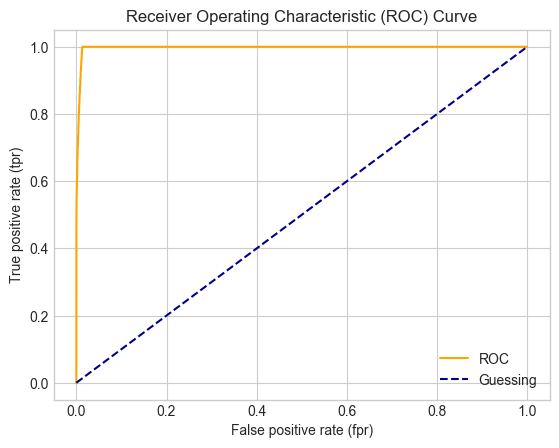


Results on TEST data:


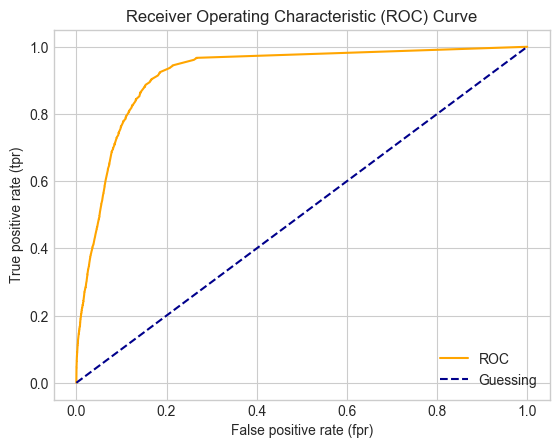

In [319]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = labelencoded_rfc.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = labelencoded_rfc.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [320]:
# Scores
print("\nResults on TRAINING data:")
labelencoded_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
labelencoded_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      98.76%
Precision           :       0.84
Recall              :       1.00
F1 score            :       0.91
F1 (macro) score    :       0.95
F1 (weighted) score :       0.99
ROC-AUC             :       0.99

Results on TEST data:
Accuracy            :      92.86%
Precision           :       0.48
Recall              :       0.36
F1 score            :       0.41
F1 (macro) score    :       0.69
F1 (weighted) score :       0.92
ROC-AUC             :       0.66


Finding: We can see that the model is overfit to the training data given the significant difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.

Upon first glance, the scores between the "baseline" and "labelencoded" RFC models, but we will compare with a closer look later on in the notebook.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.66 is not as good as the best simple logit models built, though.

Show feature importances

hour          0.321005
weekofyear    0.305819
id            0.133206
citytype      0.095042
dayofweek     0.088455
city          0.056473
dtype: float64

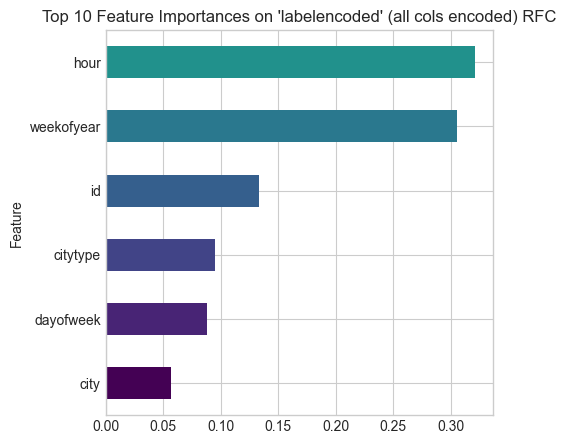

In [321]:
feat_importances = Utility.get_feature_importances_and_plot(labelencoded_rfc, X_train, '\'labelencoded\' (all cols encoded) RFC')
display(feat_importances)

## Build RandomForestClassifier model: "labelpartial"

In [322]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

What does the label-encoded dataframe look like now?

In [323]:
Utility.display_df_general_info(df_model_labelpartial)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                int64
hour                      int64
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        

In [324]:
# Confirm that 'hour' and 'weekofyear' have indeed been label-encoded
display(df_model_labelpartial['hour'].value_counts())
display(df_model_labelpartial['weekofyear'].value_counts())

# Confirm 'dayperiod' is one-hot-encoded
display(df_model_labelpartial['dayperiod_evening'].value_counts())

hour
20    7733
18    7668
13    7660
17    7636
12    7627
9     7626
16    7619
14    7610
22    7606
23    7603
15    7595
11    7588
21    7587
19    7576
10    7571
0     7570
8     7552
5     7536
1     7530
7     7530
6     7521
4     7471
2     7461
3     7450
Name: count, dtype: int64

weekofyear
41    6712
42    6700
35    6691
37    6660
36    6644
40    5722
38    4640
43    4609
34    4100
32    3360
28    3360
46    3360
20    3360
18    3360
29    3360
30    3360
13    3360
11    3360
6     3360
5     3360
48    3360
10    3358
19    3358
16    3354
47    3354
4     3354
8     3352
45    3350
31    3347
0     3340
1     3340
15    3340
7     3340
39    3340
12    3339
2     3338
9     3336
33    3325
14    3318
24    3317
25    3314
44    3310
23    3217
22    3197
21    3161
17    3125
3     2904
27    2060
26    1340
Name: count, dtype: int64

dayperiod_evening
0    120898
1     61028
Name: count, dtype: int64

## Set X and y dataframes for "labelpartial" model

In [325]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartial"

In [326]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [327]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (145540, 40)
y_train.shape: (145540,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `class_weights='balanced'` in our RandomForestClassifier

In [328]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [329]:
labelpartial_rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced')
labelpartial_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [330]:
# Get predictions for X_train and X_test
y_train_pred = labelpartial_rfc.predict(X_train)
y_test_pred = labelpartial_rfc.predict(X_test)

## Evaluate model performance: "labelpartial"

Confusion Matrix

In [331]:
# Confusion Matrix
print("\nResults on TRAINING data:")
labelpartial_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartial_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9725,10
Actual Negative,1798,134007



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,915,1608
Actual Negative,1115,32748


ROC Curve


Results on TRAINING data:


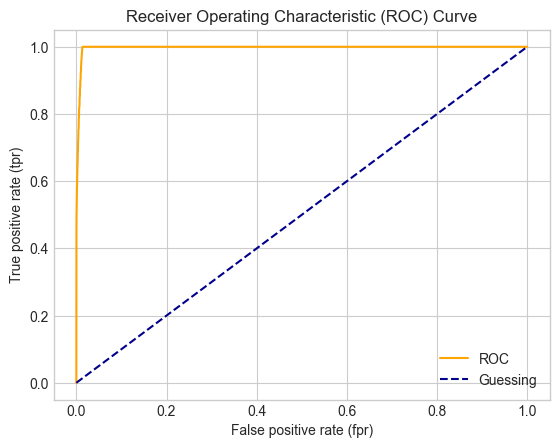


Results on TEST data:


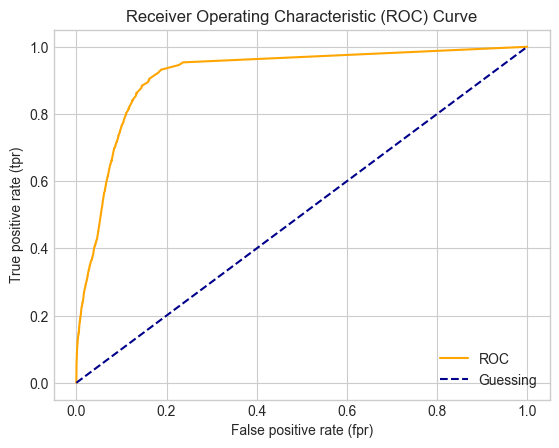

In [332]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = labelpartial_rfc.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = labelpartial_rfc.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [333]:
# Scores
print("\nResults on TRAINING data:")
labelpartial_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartial_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      98.76%
Precision           :       0.84
Recall              :       1.00
F1 score            :       0.91
F1 (macro) score    :       0.95
F1 (weighted) score :       0.99
ROC-AUC             :       0.99

Results on TEST data:
Accuracy            :      92.52%
Precision           :       0.45
Recall              :       0.36
F1 score            :       0.40
F1 (macro) score    :       0.68
F1 (weighted) score :       0.92
ROC-AUC             :       0.66


Show feature importances

weekofyear                0.343046
hour                      0.224841
citytype_urban            0.071132
dayperiod_night           0.057218
dayperiod_evening         0.032562
id_plc                    0.016482
id_uah                    0.015897
id_gnch                   0.015360
id_mch                    0.014878
city_Edmonton             0.014658
dayofweek_Monday          0.012624
dayofweek_Saturday        0.012102
dayofweek_Sunday          0.011206
id_shc                    0.009811
dayofweek_Tuesday         0.009774
dayofweek_Wednesday       0.008893
id_stollery               0.008719
id_fmc                    0.008513
dayofweek_Thursday        0.008310
city_Medicine Hat         0.008132
id_nchc                   0.008108
id_rah                    0.007772
id_rgh                    0.007411
city_Lethbridge           0.007349
id_mhrh                   0.006953
id_crh                    0.005824
id_lch                    0.005288
id_dgh                    0.005221
city_Leduc          

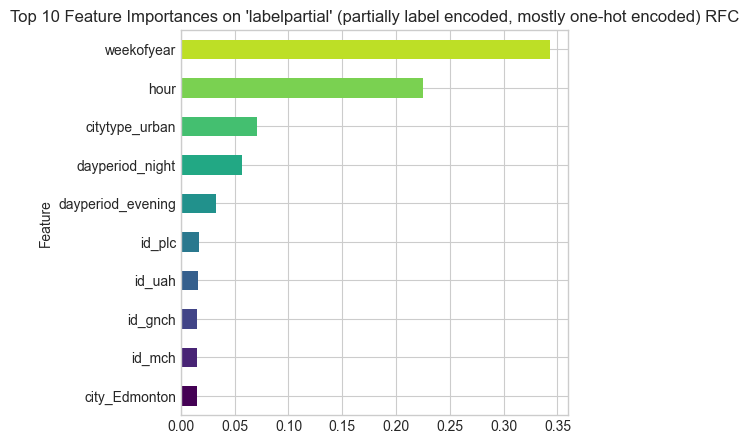

In [334]:
feat_importances = Utility.get_feature_importances_and_plot(labelpartial_rfc, X_train, '\'labelpartial\' (partially label encoded, mostly one-hot encoded) RFC')
display(feat_importances)

Finding: We can see that the model is overfit to the training data given the significant difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.

Upon first glance, the scores between the "baseline" and "labelencoded" RFC models, but we will compare with a closer look later on in the notebook.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.66 is not as good as the best simple logit models built, though.

# Evaluate performance of all models

In [335]:
df_compare = pd.DataFrame({
    'baseline_train': baseline_train_scores,
    'baseline_test': baseline_test_scores,
    'onehot_train': onehot_train_scores,
    'onehot_test': onehot_test_scores,
    'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
    'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
    'labelencoded_train': labelencoded_train_scores,
    'labelencoded_test': labelencoded_test_scores,
    'labelpartial_train': labelpartial_train_scores,
    'labelpartial_test': labelpartial_test_scores})

df_compare

,baseline_train,baseline_test,onehot_train,onehot_test,onehot_dropdayperiod_train,onehot_dropdayperiod_test,labelencoded_train,labelencoded_test,labelpartial_train,labelpartial_test
accuracy,0.99,0.93,0.99,0.93,0.99,0.92,0.99,0.93,0.99,0.93
precision,0.84,0.45,0.84,0.45,0.84,0.42,0.84,0.48,0.84,0.45
recall,1.00,0.36,1.00,0.36,1.00,0.33,1.00,0.36,1.00,0.36
f1,0.91,0.40,0.91,0.40,0.92,0.37,0.91,0.41,0.91,0.40
f1_macro,0.95,0.68,0.95,0.68,0.95,0.66,0.95,0.69,0.95,0.68
f1_weighted,0.99,0.92,0.99,0.92,0.99,0.92,0.99,0.92,0.99,0.92
roc_auc,0.99,0.66,0.99,0.66,0.99,0.65,0.99,0.66,0.99,0.66


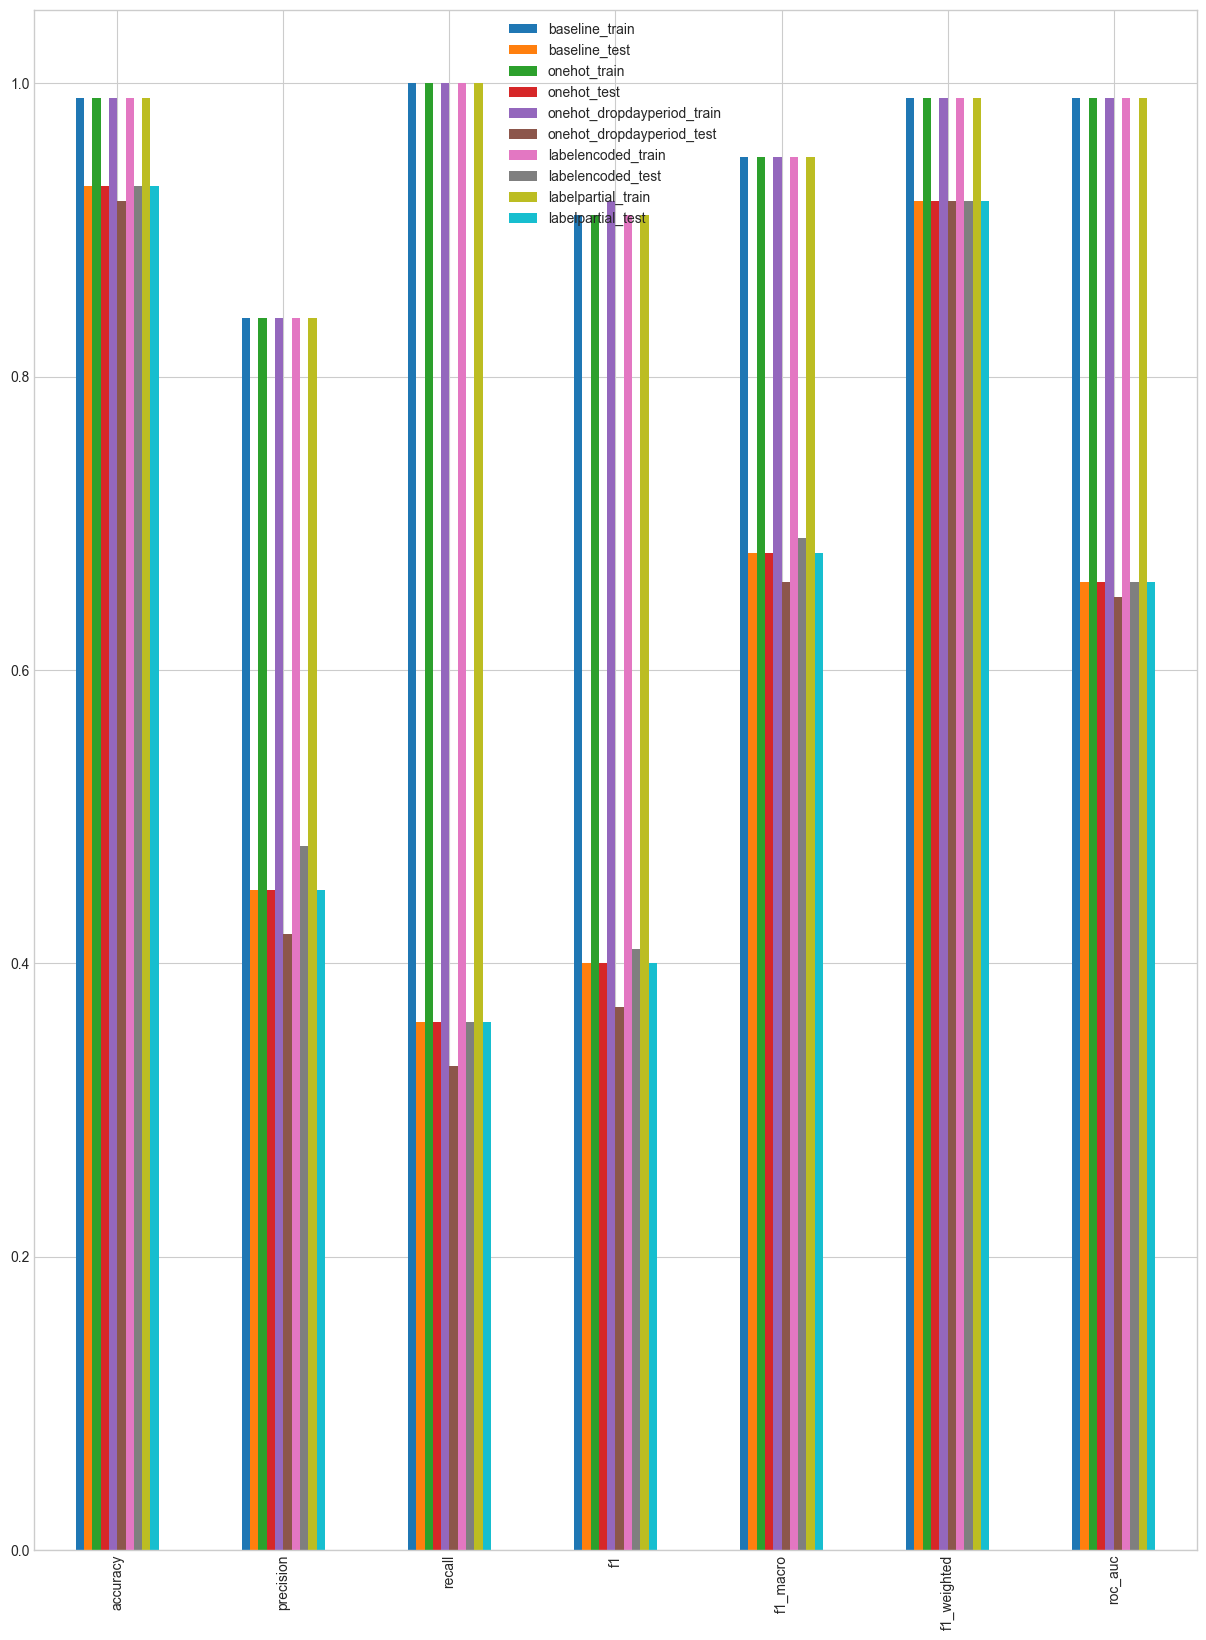

In [336]:
# Plot the scores
sns.set_palette("tab10")
df_compare.plot.bar(figsize=(15,20));

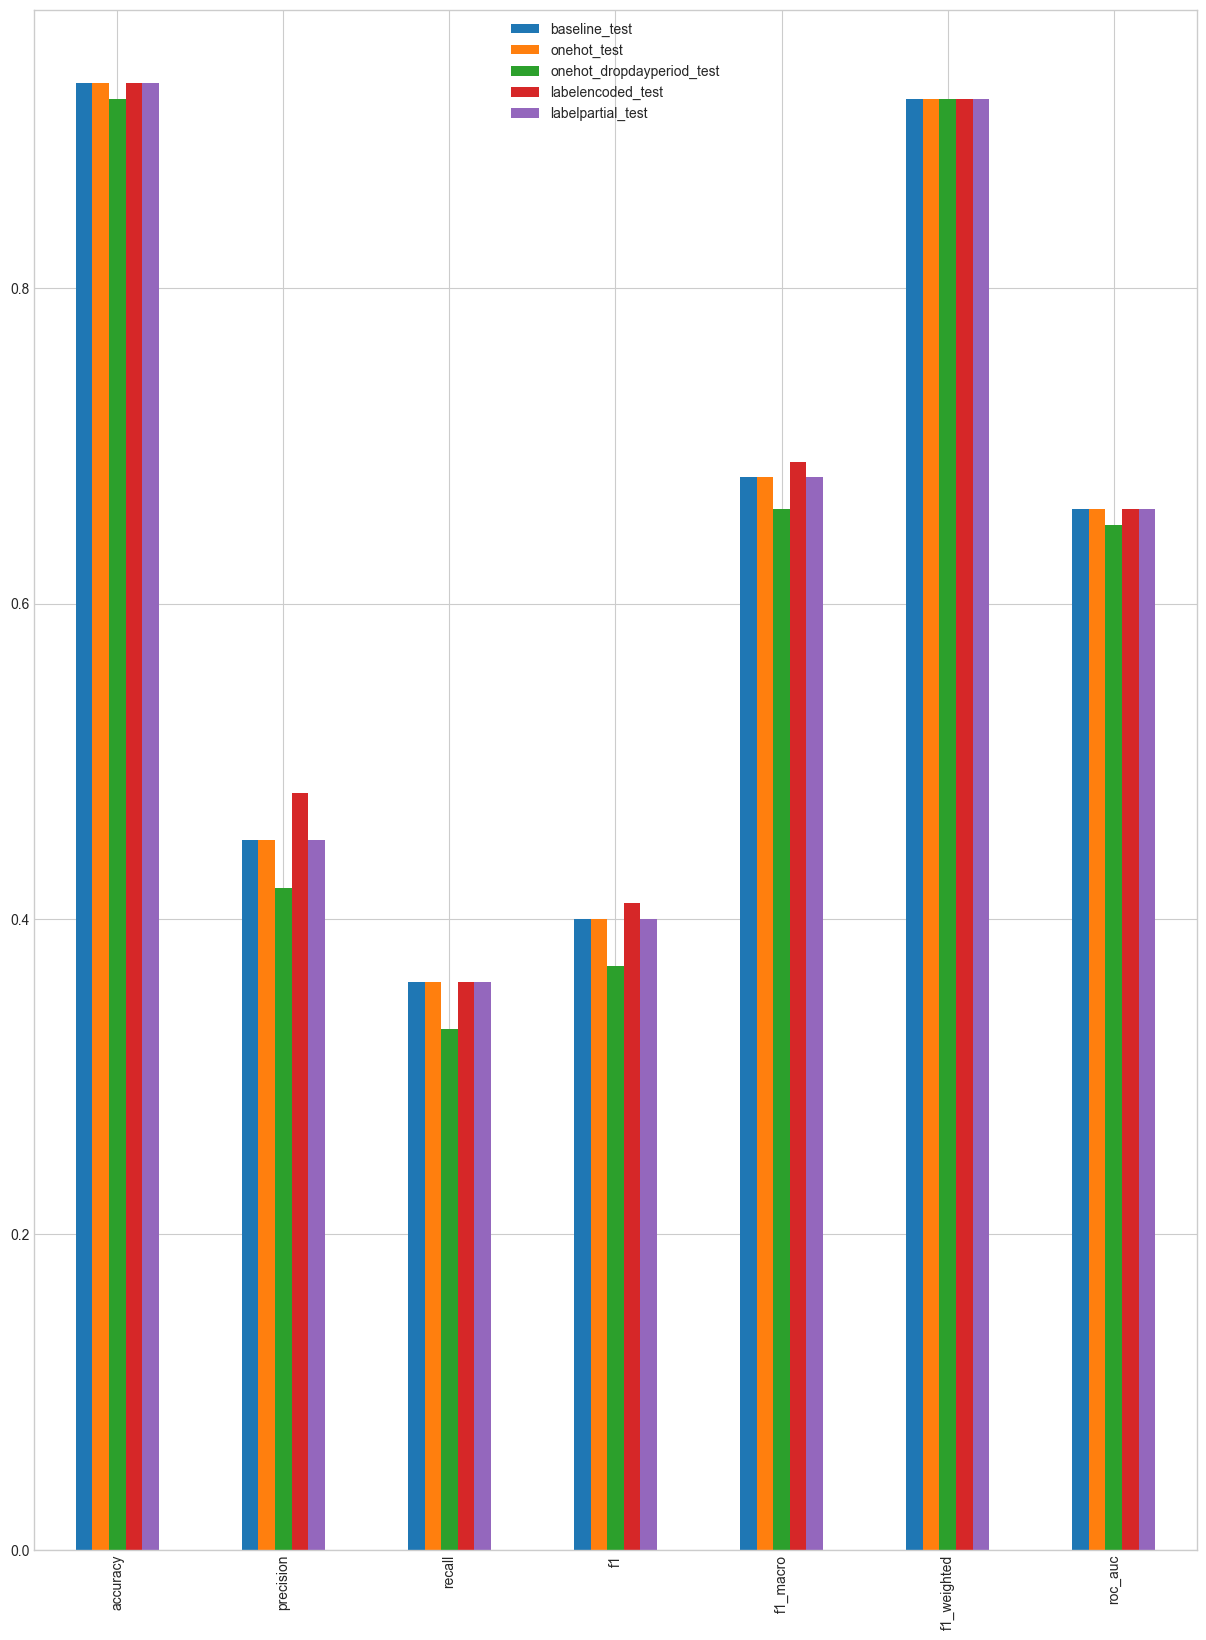

In [261]:
# Plot the scores - test only!
sns.set_palette("tab10")
df_compare[['baseline_test', 'onehot_test', 'onehot_dropdayperiod_test', 'labelencoded_test', 'labelpartial_test']].plot.bar(figsize=(15,20));

Finding:  The above shows that **all** the models are badly overfit.

Ironically, the `labelencoded` model seems to generally be equal or slightly better than all the rest of the models on TEST data, for precision, recall, F1 macro and roc_auc.

Tuning hyperparameters for RandomForestClassifier and changing the scoring that is used to evaluate for the best model, may help us avoid overfitting.

We will utilize the `labelpartial` X_train and X_test dataset for the GridSearchCV with hyperparameter tuning, next (even though `labelencoded` is equal or better than `labelpartial`, surprisingly!).  I choose to use this because it has high dimensionality and the GridSearch on `max_features` may help with not overfitting.

# Can We Do Better on Random Forest Model?

Can we run this dataset in a GridSearchCV, using an exhaustive search against the various hyperparameters for the RandomForestClassifier, and change the scoring to be `f1_macro`, that may help with the overfitting?

Hyperparameters to tune:
* `max_features`:  default 'sqrt', but try some numbers and the default 'sqrt' and 'log2' calculators.  I have 40 features.
* `n_estimators`:  log scale from 10 to 2000
* `max_samples`:  between 0 and 1: determines what percentage of size of training dataset to make the bootstrap sample to train each decision tree from.  Try smaller numbers than the dataset and include 'None' (this is the default which makes the sample size the same size as training dataset)
* `max_depth`: None is the default (i.e. no maximum depth).  Try 1-8 and include None.
* `bootstrap`: Defaulted to 'True'.  Specify default.
* `class_weight`: `balanced`` and `balanced_subsample`
* `oob_score`: Set to `True`


### Ensure everything is set up from base, for 'labelpartial' situation!

In [221]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

What does the label-encoded dataframe look like now?

In [222]:
Utility.display_df_general_info(df_model_labelpartial)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                int64
hour                      int64
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        

## Set X and y dataframes for "labelpartial" model

In [223]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartial"

In [224]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [225]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (145540, 40)
y_train.shape: (145540,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Define GridSearchCV with:
* param_grid with hyperparameters as defined in cells above
* RandomForestClassifier instantiated with Utility.RANDOM_STATE_CONST
* `scoring = 'f1_macro'`
* `n_jobs = -1`
* `error_score = 'raise'`
* `verbose=2`

In [226]:
# Instantiate RFC classifier object
#rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST)
rfc = RandomForestClassifier(random_state=Utility.RANDOM_STATE_CONST, class_weight='balanced', bootstrap=True, oob_score=True)

# Define the param_grid for GridSearchCV

# Initial thought - abandoned without trying because too many combinations
# param_grid = {
#     'n_estimators': [10, 50, 80, 120, 500, 1000, 1500, 2000],
#     'max_features': [None, 'sqrt', 'log2', 2, 8, 15, 20, 25, 30], 
#     'max_samples': [None, 0.6, 0.7, 0.8, 0.9],
#     'max_depth' : [None, 5, 8, 10, 15, 20],
#     'oob_score' : [True],
#     'bootstrap': [True],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# Run #1
# Ran out of memory locally and also on Google Colab - abandoned because never returned
# param_grid = {
#     'n_estimators': [10, 50, 80, 120, 500, 1000],
#     'max_features': [None, 'sqrt', 'log2', 2, 8, 15, 20, 30],
#     'max_samples': [None, 0.7, 0.8, 0.9],
#     'max_depth' : [None, 5, 8, 10, 15, 20],
#     'oob_score' : [True],
#     'bootstrap': [True],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# # Run #2 - Timed out/memory (Dec 1 23:30)
# param_grid = {
#     'n_estimators': [50, 100, 200, 500],
#     'max_features': [None, 'sqrt', 'log2', 2, 8, 15, 20, 30],
#     'max_samples': [None, 0.7, 0.8, 0.9],
#     'max_depth' : [None, 5, 8, 10, 15, 20]
# }

# Run #3 (Dec 2 04:00) - Timed out/memory (even on a GPU machine)
# param_grid = {
#     'n_estimators': [50, 100, 200, 500],
#     'max_features': [None, 'sqrt', 'log2', 15, 20, 30],
#     'max_samples': [None, 0.7, 0.8],
#     'max_depth' : [5, 8, 10, 15, 20]
# }

# Run #4 (Dec 2 11:36)
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': [None, 'sqrt', 2, 8, 15, 20, 30],
    'max_samples': [0.7, 0.8, 0.9],
    'max_depth' : [5, 8, 10, 15, 20]
}

In [227]:
# # Create GridSearchCV using:
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)

# # Fit the model
# grid_search.fit(X_train, y_train)

# GridSearch complete

In [228]:
# grid_search.best_params_

In [229]:
# grid_search.best_score_

## Evaluate model performance: "grid_search.best_estimator_"

In [230]:
# # Get preds from grid_search.best_estimator_
# y_train_pred = grid_search.best_estimator_.predict(X_train)
# y_test_pred = grid_search.best_estimator_.predict(X_test)

Confusion Matrix

In [231]:
# # Confusion Matrix
# print("\nResults on TRAINING data:")
# gridbest_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

# print("\nResults on TEST data:")
# gridbest_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)

ROC Curve

In [232]:
# # ROC Curve
# print("\nResults on TRAINING data:")
# y_train_probs_positive = grid_search.best_estimator_.predict_proba(X_train)[:,1]
# train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
# Utility.plot_roc_curve(train_fpr, train_tpr)

# print("\nResults on TEST data:")
# y_test_probs_positive = grid_search.best_estimator_.predict_proba(X_test)[:,1]
# test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
# Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [233]:
# # Scores
# print("\nResults on TRAINING data:")
# gridbest_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

# print("\nResults on TEST data:")
# gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)

# Evaluate performance of `grid_search.best_estimator_` vs. the `labelencoded` and `labelpartial` from before

In [234]:
# #Recall df_compare definition from above
# # df_compare = pd.DataFrame({
# #     'baseline_train': baseline_train_scores,
# #     'baseline_test': baseline_test_scores,
# #     'onehot_train': onehot_train_scores,
# #     'onehot_test': onehot_test_scores,
# #     'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
# #     'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
# #     'labelencoded_train': labelencoded_train_scores,
# #     'labelencoded_test': labelencoded_test_scores,
# #     'labelpartial_train': labelpartial_train_scores,
# #     'labelpartial_test': labelpartial_test_scores})

# df_compare['gridbest_train'] = gridbest_train_scores
# df_compare['gridbest_test'] = gridbest_test_scores
# df_compare

In [235]:
# # Plot the scores for the 3 different models we are interested in
#sns.set_palette("tab10")
# df_compare[['labelpartial_train', 'labelpartial_test', 'labelencoded_train', 'labelencoded_test', 'gridbest_train', 'gridbest_test']].plot.bar(figsize=(15,20));

Draw another graph comparing all scores only against the test versions of those scores, since those are the ones that matter most (unseen data)

In [236]:
# # Plot the scores - test only!
#sns.set_palette("tab10")
# df_compare[['labelpartial_test', 'labelencoded_test', 'gridbest_test']].plot.bar(figsize=(10,15));

See the actual scores compared side by side on balanced_test vs. gridbest_test

In [237]:
# df_compare[['labelpartial_test', 'labelencoded_test', 'gridbest_test']]

### Important Note:  GridSearch Execution Failed!

Findings:  The GridSearch space has been reduced significantly over 4 run attempts (2 with GPU) and has failed or not completed each time.  The Run #1 ran for 36 hours without returning.  Run #4 ran for 12 hours on Google Colab and execution failed. Therefore, we not be able to complete any comparisons of the existing "best models" with the `grid_search.best_estimator_`.  This section may be completed in future with a RandomizedSearch.

This has been an interesting lesson and finding about the amount of memory that RFC trees take up in comparison to Simple Logit and XGBoost.

# Save the Models and `grid_search` object

Save:
* `labelencoded`: The best of the "regular" RFC (non GridSearched) models, with default settings and `class_weight=balanced`
* `labelpartial`: The 2nd best of the "regular" RFC (non GridSearched) models, with default settings and `class_weight=balanced`. Higher dimensionality but ostensibly the "right" way to treat features rather than encoding them and giving them a sense of 'ordinality' when there is none in reality.
* `grid_search.best_estimator_`:  Using data treatments the same as `labelpartial` model, the model resulting from Grid Search CV on various hyperparameters.
* `grid_search`:  The grid_search object for future reference, where I can read `.best_params_`, `.cv_result_`, `.best_score_` in future if needed

In [238]:
# Setup paths and filenames

relativepath_models = Utility.MODELS_RELATIVE_PATH

labelencoded_filename = 'labelencoded_rfc.pkl'
labelpartial_filename = 'labelpartial_rfc.pkl'
#grid_search_filename = 'labelpartial_rfc_grid_search.pkl'
#grid_search_best_estimator_filename = 'labelpartial_rfc_grid_search_best_estimator.pkl'

In [239]:
# Write all 4 objects to disk

# with open(relativepath_models + labelencoded_filename, 'wb') as f:
#     pickle.dump(labelencoded_rfc, f)

# with open(relativepath_models + labelpartial_filename, 'wb') as f:
#     pickle.dump(labelpartial_rfc, f)

# #with open(relativepath_models + grid_search_filename, 'wb') as f:
# #    pickle.dump(grid_search, f)

# #with open(relativepath_models + grid_search_best_estimator_filename, 'wb') as f:
# #    pickle.dump(grid_search.best_estimator_, f)

### The 2 models were > 100MB so need to be GZip'd.  Here is the replacement code from the above.

In [240]:
import gzip

relativepath_models = Utility.MODELS_RELATIVE_PATH

#labelencoded_filename = 'labelencoded_rfc.pkl.gz'  # Note the .gz extension
labelencoded_filename = 'rfc_labelencoded.pkl.gz'  # Note the .gz extension

#labelpartial_filename = 'labelpartial_rfc.pkl.gz'  # Note the .gz extension
labelpartial_filename = 'rfc_labelpartial.pkl.gz'  # Note the .gz extension

with gzip.open(relativepath_models + labelencoded_filename, 'wb') as f:
    pickle.dump(labelencoded_rfc, f)

with gzip.open(relativepath_models + labelpartial_filename, 'wb') as f:
    pickle.dump(labelpartial_rfc, f)

### Note about GZIP compression:

Here's how to uncompress the above files and load them in a different (or this same) notebook.

```python
with gzip.open(relativepath_models + labelencoded_filename, 'rb') as f:
    labelencoded_rfc = pickle.load(f)

with gzip.open(relativepath_models + labelpartial_filename, 'rb') as f:
    labelpartial_rfc = pickle.load(f)
```

# Save the model results `df_compare` file

In [241]:
# Setup paths and filenames

relativepath_output = Utility.OUTPUT_RELATIVE_PATH
rfc_scores_filename = 'rfc_compare_model_scores.csv'

In [242]:
# Write csv to disk
df_compare.to_csv(relativepath_output + rfc_scores_filename)